# Assignment 1
**Course:** Computational Modeling of Cognition (COGS202)
    
---

## General Instructions

- **Answer format**  
  - **Conceptual questions:** fill in the *Markdown* cells with your written responses.  
  - **Implementation tasks:** complete the *code* cells with your solutions.

- **Submission requirements**  
  1. **Jupyter Notebook** (`.ipynb`) with all cells executed and outputs visible.  
  2. **PDF Export** of the same notebook (e.g. via **File → Download As → PDF**).  

- **Collaboration policy**  
  - You may work in **teams of up to 2 students**.  
  - Include both team members’ names and student IDs at the top of your notebook.  

- **Questions & Support**  
  - Use our Slack workspace for any clarifications or troubleshooting.  
  - Feel free to set up an OH appointment. 


If you’re new to Jupyter Notebooks, Python, or libraries like NumPy and Pandas, check out these tutorials to get started:  
[COGS202 Python Libraries Tutorials](https://github.com/mkhosla-ucsd/cogs202-notebooks/tree/main/python_libraries_tutorials)  

## Section I: Computational Modeling of Human Reading Times

### Reading‑Time Dataset

In the first section of the assignment, we will try to model human reading times for different words using several word-level features. We will load a human reading‑time dataset collected by Futrell et al. (https://link.springer.com/article/10.1007/s10579-020-09503-7) into a Pandas DataFrame. Pandas is a powerful Python library for data manipulation and analysis—see the [official documentation](https://pandas.pydata.org/docs/) for more details and check out the tutorial linked above if you want to learn more.

```python
import pandas as pd
df = pd.read_csv('futrell_reading_times_dataset.csv')


In [1]:
# If you’re missing any of these, run this cell to install all dependencies:
!pip install pandas statsmodels scikit-learn numpy matplotlib scipy torch torchvision pillow

In [2]:
import pandas as pd
df = pd.read_csv('futrell_reading_times_dataset.csv')

### Here is some information related to the dataset

| Column            | What it Measures                                                          | Why It Matters for Reading‑Time Models                              |
|-------------------|---------------------------------------------------------------------------|---------------------------------------------------------------------|
| **word**          | Orthographic form (token).                                                | —                                                                   |
| **mean_RT**       | Mean reading time for the word (ms), averaged across readers.             | This is the response variable you will model.                       |
| **chars**         | Number of characters in the word (`len(word)`).                         | Longer strings often require more visual processing.                |
| **log_freq**      | **Log‑scaled corpus frequency**: `log10(count / corpus_size)`.            | More frequent words have stronger memory traces, predicting shorter reading times. |
| **gpt2S_surp**    | **Unigram surprisal (GPT‑2 Small)**: $-\log p(w)$ assigned by GPT‑2 Small in isolation. | Captures lexical rarity under a lightweight transformer model.      |
| **gpt2B_surp**    | **Unigram surprisal (GPT‑2 Base)**: $-\log p(w)$ assigned by GPT‑2 Base in isolation.  | Reflects how a medium‑scale model estimates word predictability.    |
| **gpt2L_surp**    | **Unigram surprisal (GPT‑2 Large)**: $-\log p(w)$ assigned by GPT‑2 Large in isolation. | Provides insights from a high‑capacity transformer on lexical predictability. |

### Conceptual Notes on Some Predictors

* **Word Frequency (`log_freq`)**  
  In psycholinguistics, more frequent words have been shown to have stronger memory traces. Taking the base‑10 logarithm of raw frequency linearizes the Zipf distribution and makes effect sizes interpretable—each unit change corresponds to a ten‑fold change in raw count.

* **Unigram Surprisal (`gpt2*_surp`)**  
  From information theory, surprisal quantifies how much “information” a word carries:  
  $
    \text{surprisal}(w) = -\log p(w),
  $ 
  where $p(w)$ is the probability assigned by a language model when no context is provided (hence “unigram”).  
  - **Low surprisal** (high $p(w)$) → lower processing load  
  - **High surprisal** (low $p(w)$) → higher processing effort  

  Comparing surprisal across GPT‑2 Small, Base, and Large allows you to test the robustness of predictability effects across models of increasing scale.

You will combine length, frequency, and surprisal predictors to build GLMs that explain variability in **mean_RT**.

To model the reading time, we need to first choose a GLM family. 


### 1. Choosing a GLM Family (Multiple‑Choice)


**Visualizing candidate GLM families**

Below we generate and plot four common probability distributions for GLM families to build intuition about their shapes and supports:

1. **Gaussian (Normal)**   

2. **Poisson**  
   
3. **Bernoulli**  
      
4. **Gamma**  
 

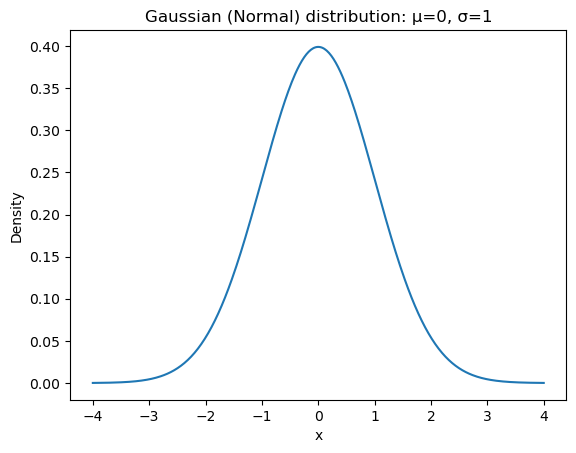

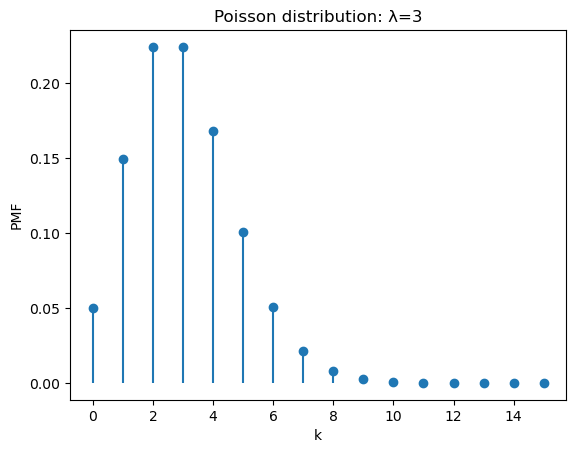

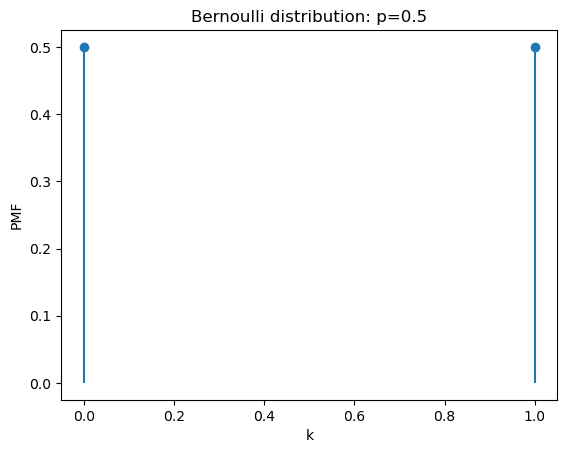

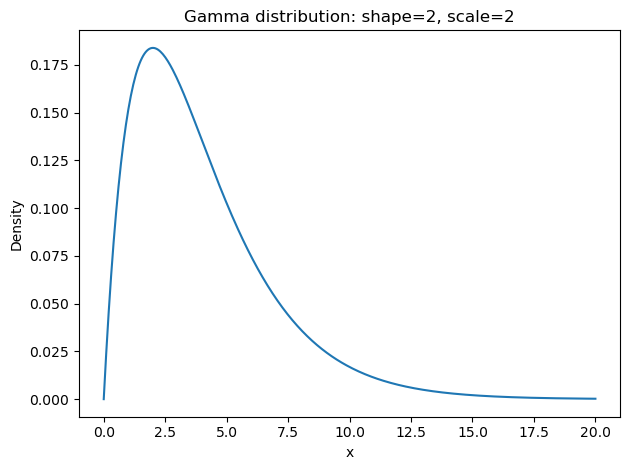

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, bernoulli, gamma

# 1. Gaussian (Normal)
x_norm = np.linspace(-4, 4, 400)
y_norm = norm.pdf(x_norm, loc=0, scale=1)
plt.figure()
plt.plot(x_norm, y_norm)
plt.title('Gaussian (Normal) distribution: μ=0, σ=1')
plt.xlabel('x')
plt.ylabel('Density')

# 2. Poisson
k_poisson = np.arange(0, 16)
pmf_poisson = poisson.pmf(k_poisson, mu=3)
plt.figure()
plt.stem(k_poisson, 
         pmf_poisson, basefmt=" ", 
         #use_line_collection=True
         )
plt.title('Poisson distribution: λ=3')
plt.xlabel('k')
plt.ylabel('PMF')

# 3. Bernoulli
k_bern = np.array([0, 1])
pmf_bern = bernoulli.pmf(k_bern, p=0.5)
plt.figure()
plt.stem(k_bern, pmf_bern, basefmt=" ", 
        #  use_line_collection=True
         )
plt.title('Bernoulli distribution: p=0.5')
plt.xlabel('k')
plt.ylabel('PMF')

# 4. Gamma
x_gamma = np.linspace(0, 20, 400)
y_gamma = gamma.pdf(x_gamma, a=2, scale=2)
plt.figure()
plt.plot(x_gamma, y_gamma)
plt.title('Gamma distribution: shape=2, scale=2')
plt.xlabel('x')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


Reading times are continuous, strictly positive and typically right‑skewed.   
### Question 1. Choosing the GLM Family for RT data: 
Among the following options, which of the following GLM specifications is most suitable for modelling **mean_RT**? [**1 point**]

| Option | Distribution | 
|--------|--------------|
| **A**  | Gaussian     | 
| **B**  | Poisson      | 
| **C**  | Bernoulli    | 
| **D**  | Gamma        | 

Select one option **and** write 1-2 sentences explaining your choice.

Answer: D. Gamma 

Explanation: It most closly resembles the data because it is positive and right skewed.

Hint: you can also try visualizing the distribution of mean RT values with the following code 
```python
import matplotlib.pyplot as plt
plt.hist(df['mean_RT'], bins=30, density=True, alpha=0.6, color='g')


(array([9.24245449e-04, 7.95511261e-03, 1.14375374e-02, 6.81631018e-03,
        4.09308699e-03, 1.79897775e-03, 7.09688470e-04, 2.80574511e-04,
        3.63096426e-04, 1.65043830e-04, 8.25219151e-05, 1.65043830e-05,
        6.60175320e-05, 1.65043830e-05, 1.65043830e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.65043830e-05,
        4.95131490e-05, 0.00000000e+00, 3.30087660e-05, 0.00000000e+00,
        1.65043830e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.65043830e-05]),
 array([ 271.39189189,  300.0667455 ,  328.7415991 ,  357.4164527 ,
         386.09130631,  414.76615991,  443.44101351,  472.11586712,
         500.79072072,  529.46557432,  558.14042793,  586.81528153,
         615.49013514,  644.16498874,  672.83984234,  701.51469595,
         730.18954955,  758.86440315,  787.53925676,  816.21411036,
         844.88896396,  873.56381757,  902.23867117,  930.91352477,
         959.58837838,  988.26323198, 1016.938

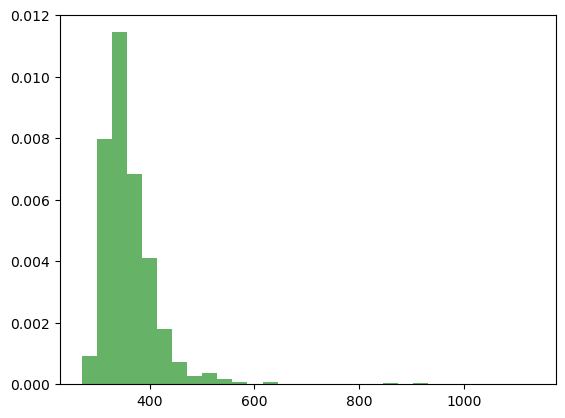

In [4]:
import matplotlib.pyplot as plt
plt.hist(df['mean_RT'], bins=30, density=True, alpha=0.6, color='g')

### Question 2. Coefficient‑Sign Predictions

Assume the following linear predictor (on the link‑function scale):

$
\text{mean_RT} =
\theta_0 \;+\; \theta_1\,\text{chars}
\;+\; \theta_2\,\text{log_freq}
\;+\; \theta_3\,\text{unigram_surp}.
$

For each coefficient, indicate whether you expect it to be **positive (+)**, **negative (–)**, or **approximately zero (0)**, **and provide a one‑sentence justification**. [**1 point**]

| Coefficient | Expected Sign | Justification |
|-------------|---------------|---------------|
| $\theta_1$ (chars) | + | I would expect longer words to take more cognitive processing and this would slow reading time. |
| $\theta_2$ (log_freq) | - | I would expect more frequent words to be easier to process as a result of them being seen more commenly and thus lead to a lower reading time. |
| $\theta_3$ (surp) | + | Maybe suprising words would not be at front of mind and take more time to read. |

---

### Question 3: Quick Model Checks  

| Prompt | Your Response |
|--------|---------------|
| **3a.** Name one diagnostic plot you would examine to evaluate whether your chosen GLM fits the data well. [**1 point**] | I may use a scatter plot to see if there is some visually apparent linear relationship between the predictor and outcome variables. I could also plot the slope and intercept to see if the line seems reasonable. |
| **3b.** Describe one approach to assess how well your model generalizes to unseen data. [**1 point**]| You could see if the trend line form the previous step (the slope and intercept line) visualally follows the scatter plot of new data or if the trend is different. You could also use and encoding-decoding framework to see you can use your previous model parameters to predict the outcomes of the new data and the quantify fit with some sort of error finction like root mean squared error. |

---



## Question 4 – Implementation Tasks
[**4 points**]

1. **Fit Two Competing Models**  
   *Model 1*: Fit a GLM using the distribution you selected in Question 1 with all three predictors (by default choose surprisal estimates from the GLM-small model).  
   *Model 2*: Fit another GLM using the distribution you didn't select in Question 1 with all three predictors.  

2. **Compare Models**  
   Use the diagnostic plot you suggested above to evaluate the fit of Model 1 
   
3. **Quantitative Metrics** 
Report a predictive‑error metric (on held-out dataset) for both models. Indicate which model performs better. 

4. **Assess GPT‑2 Scale Effects**  
Using your selected GLM family, fit three separate models—each including only one surprisal predictor (`gpt2S_surp`, `gpt2B_surp`, or `gpt2L_surp`). Then compare their fits via the chosen metric on held-out data.  



*Hints:*  
- Use `pandas.read_csv` to load the data as illustrated above.  
- Fit models with `statsmodels.api.glm`.  
- For a train/test split, `sklearn.model_selection.train_test_split` is helpful.  
- `sklearn.metrics` has implementations of several widely used error metrics
- Diagnostic plots can be drawn with `matplotlib' library.   

**Below is starter code with `TODO` markers—simply fill in those spots to complete your analysis.**

In [5]:
# -----------------------------------------------------------------------
# Helper functions for Part 2
# -----------------------------------------------------------------------
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np

def construct_design_matrix(df, predictors, target, add_intercept=True):
    """
    Build the design matrix (X) and response vector (y).

    Parameters
    ----------
    df : pandas.DataFrame
        The full dataset.
    predictors : list of str
        Column names to use as predictors.
    target : str
        Column name of the response variable.
    add_intercept : bool
        If True, adds a column of 1s for the intercept term.

    Returns
    -------
    X : pandas.DataFrame
    y : pandas.Series
    """
    # ---------------------------------------------------------------
    # TODO 1 – Select the predictor columns from df
    # ---------------------------------------------------------------
    X = df[predictors]     

    # Optional intercept
    if add_intercept:
        X = sm.add_constant(X)

    # ---------------------------------------------------------------
    # TODO 2 – Select the target column from df
    # ---------------------------------------------------------------
    y = df[target]

    return X, y


def fit_glm(X, y, family_name=None):
    """
    Fit a GLM using statsmodels.

    Parameters
    ----------
    X : pandas.DataFrame
        Design matrix (must already include an intercept column if desired).
    y : pandas.Series
        Response variable.
    family_name : {"gaussian", "poisson", "logistic"}
        Which GLM family to use.

    Returns
    -------
    result : statsmodels.genmod.generalized_linear_model.GLMResults
    """
    families = {
        "gaussian": sm.families.Gaussian(sm.families.links.identity()),
        "poisson" : sm.families.Poisson(),
        "logistic": sm.families.Binomial(),
        "gamma": sm.families.Gamma()
    }

    # ------------------------------------------------------------------------------------
    # TODO 3 – Look up the correct family object and plug in the correct arguments for GLM
    # ---------------------------------------------------------------
    fam = families[family_name]
    
    # Fit the GLM: https://www.statsmodels.org/stable/glm.html
    model = sm.GLM(y,X,family=fam)
    result = model.fit()
    return result

In [6]:
df = pd.read_csv('futrell_reading_times_dataset.csv') 
# df.head()

In [7]:
# ----------------------------------------------------------------------------
# TODO 4 – Specify the predictors and target columns from the pandas dataframe
# -----------------------------------------------------------------------------

predictors = ['chars','log_freq','gpt2S_surp']
target = 'mean_RT'
X, y = construct_design_matrix(df, predictors, target)

# Train‑test split (80 / 20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------------------------------------------------------
# TODO 5– Fit the GLM model by specifying the X,y variables and the GLM Family that you selected in Question 1
# ------------------------------------------------------------------------------------------------------------
m1 = fit_glm(X_train, y_train, family_name='gamma')
print(m1.summary())

# Predict & compute test prediction error
preds_1 = m1.predict(X_test)
# ---------------------------------------------------------------------------------------------------------------------------------------
# TODO 6– Compute the error metric to evaluate the goodnest of your predictions. Replace 'chosen_error_metric' with your chosen metric
# ---------------------------------------------------------------------------------------------------------------------------------------
metric_1 = ((y_test - preds_1)**2).mean(axis=0) # mean squared error
print("Test metric for model 1:", metric_1)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_RT   No. Observations:                 1690
Model:                            GLM   Df Residuals:                     1686
Model Family:                   Gamma   Df Model:                            3
Link Function:           InversePower   Scale:                        0.022133
Method:                          IRLS   Log-Likelihood:                -8926.9
Date:                Mon, 28 Apr 2025   Deviance:                       28.908
Time:                        12:31:04   Pearson chi2:                     37.3
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09713
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026   8.23e-05     32.091      0.0

/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [8]:
# ---------------------------------------------------------------------------------------------------------------------
# TODO 7– Fit the GLM model by specifying the X,y variables and another GLM Family that you didn't select in Question 1
# ---------------------------------------------------------------------------------------------------------------------
m2 = fit_glm(X_train, y_train, family_name='poisson')
print(m2.summary())

# Predict & compute test prediction error
preds_2 = m2.predict(X_test)

# ------------------------------------------------------------------------------------------------------------
# TODO 8– Compute the error metric to evaluate the goodnest of your predictions for the second model. Replace 'chosen_error_metric' with your chosen metric
# ------------------------------------------------------------------------------------------------------------
metric_2 = ((y_test - preds_2)**2).mean(axis=0) # mean squared error
print("Test metric for model 2:", metric_2)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                mean_RT   No. Observations:                 1690
Model:                            GLM   Df Residuals:                     1686
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12404.
Date:                Mon, 28 Apr 2025   Deviance:                       11764.
Time:                        12:31:04   Pearson chi2:                 1.36e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.5624
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9335      0.011    558.838      0.0

/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [9]:
preds_1

596     367.220643
1992    326.484962
422     352.640339
289     355.913686
196     359.183864
           ...    
411     384.056580
561     351.254723
438     354.285418
433     364.428089
73      348.298125
Length: 423, dtype: float64

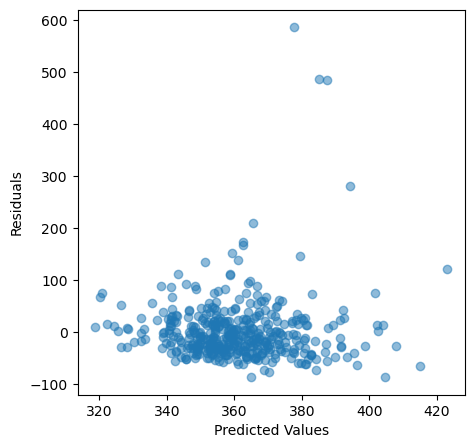

In [10]:

# ------------------------------------------------------------------------------------------------------------
# TODO 9– Add the code for diagnostic plot below to visualize the fit 
# ------------------------------------------------------------------------------------------------------------
f, ax = plt.subplots(figsize =  (5,5)) 
residuals = y_test - preds_1
ax.scatter(preds_1, residuals, alpha=0.5) #resduals plot
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


In [11]:

# ------------------------------------------------------------------------------------------------------------
# TODO 10– Fit the model with different GPT2-* models 
# ------------------------------------------------------------------------------------------------------------
for surp in ['gpt2S_surp','gpt2B_surp','gpt2L_surp']:
    X, y = construct_design_matrix(df, ['chars','log_freq',surp], 'mean_RT', add_intercept=True)
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    m = fit_glm(X_train, y_train, family_name='gamma') # picked bc it v slighlty better :)
    preds = m.predict(X_test)
    print(f'{surp} →Metric: {((y_test - preds)**2).mean(axis=0)}')

gpt2S_surp →Metric: 3916.3005457359795
gpt2B_surp →Metric: 3900.07096309042
gpt2L_surp →Metric: 3742.7265252947855


/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The Invers

### Question 5 – Interpreting Results 
[**2 point**]

(a) For the two models (with different GLM families) that you fit above, indicate which model performs better.

Answer: Poisson performed very sightly better (Gaussian: 3768.52; Poisson: 3755.14).
    
(b) Which GPT‑2 variant yields the best predictive performance for **mean_RT**? What does this suggest about the influence of model size on predicting human reading times?  

Answer: gpt2L_surp yielded the best results; this suguests that larger models do improve perfomance.
    

# Section II: Computational Modeling of Human Similarity Judgements


**Total Points:** 10
    
In the paper we discussed in class (https://onlinelibrary.wiley.com/doi/10.1111/cogs.12670), Peterson and colleagues set out to bridge two worlds that have often run in parallel: the powerful feature representations learned by deep neural networks on large‐scale vision tasks, and the fine‐grained psychological spaces we infer from human similarity judgments. In classical cognitive modeling, researchers have relied on simple, low‑dimensional stimuli (colored shapes, artificial patterns) precisely because it’s tractable to infer the underlying “mental space” from human generalization data. 

But real‑world objects—animals, fruits, tools—live in a massively high‑dimensional space of visual variation. Deep neural networks like ResNet‑50 trained on large-scale object categorization in ImageNet discover rich feature embeddings for such images, and Peterson et al. show that those raw embeddings already predict human similarity judgments surprisingly well. Crucially, they then demonstrate that a simple transformation—a reweighting of the feature space—can correct systematic mismatches and nearly double the explained variance, bringing machine representations into close alignment with human psychological structure.

This work matters for cognitive modeling because it shows how we can use powerful image features from deep neural networks to build psychological representations of real‑world objects


**Instructions:**  
Below we will try to loosely mimic the pipeline proposed in Peterson et al. (2018) for modeling human similarity judgements using deep neural network representations [Note that the precise neural network used for getting the embeddings varies for example]. 


### Load the Human Similarity Judgements Data 

In [12]:
import scipy.io as sio
import numpy as np

data       = sio.loadmat('turkResults_CogSci2016.mat')
idx        = data['animals_big_idx'][0]            # shape (120,)
stim_files = [f'images/stim-{i:04d}.png' for i in idx]
human_sim  = data['simMatrix']                     # shape (120,120)

print(f"Num images: {len(stim_files)}")
print(f"Human similarity judgements matrix shape: {human_sim.shape}")

Num images: 120
Human similarity judgements matrix shape: (120, 120)


### Extract DNN feature embeddings for all images

***High‑Level Overview of the Feature Extraction Pipeline***

This code turns a directory of images into a feature matrix **F** by:

1. **Loading a pretrained ResNet‑50**  
   - We pull in the standard ResNet‑50 model (trained on ImageNet) and drop its final classification layer, so we can tap into the 2048‑dimensional penultimate activations instead of class scores. Think of this as a high-level feature space for images. 

2. **Defining ImageNet‐style preprocessing**  
   - Each image is resized (short side → 256 px), center‑cropped to 224×224, converted to a PyTorch tensor, and normalized with the ImageNet mean/std.  
   - This ensures inputs match the distribution the network was trained on.

3. **Batch‑processing each stimulus**  
   - For every file in `stim_files`, we load and preprocess the image, run it through the truncated ResNet, and extract a single 2048‑D feature vector.

4. **Building the feature matrix**  
   - We stack all individual feature vectors into an \(N\times 2048\) NumPy array **F**, where \(N\) is the number of stimuli.
   
5. **L₂‑normalizing each vector**  
   - Finally, we scale each row of **F** to unit length. This common step makes subsequent dot‐product or cosine‐similarity calculations more stable and comparable across images.


At the end, **F** is a clean, ready‑to‑use representation for any downstream similarity analyses or regression models.  


In [13]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def load_img(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img).unsqueeze(0)

# Penultimate feature extractor
resnet = models.resnet50(pretrained=True).eval()
feat_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

# TODO: Extract F of shape (120, 2048)
F_list = []
with torch.no_grad():
    for p in stim_files:
        x = load_img(p)         # [1,3,224,224]
        h = feat_extractor(x)   # [1,2048,1,1]
        feat = h.squeeze().cpu().numpy()
        F_list.append(feat)

F = np.vstack(F_list)
F = F / np.linalg.norm(F, axis=1, keepdims=True)
print("F shape:", F.shape)  # should be (120, 2048)


/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jonathanahern/miniconda3/envs/everything/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


F shape: (120, 2048)


### Question 1: Computing and Evaluating a Model Similarity Matrix [**3 points**]


Using the feature matrix **F** (shape 120×2048) and the human similarity matrix **human_sim** (shape 120×120) you extracted above:

1. Compute the model-predicted similarity matrix  
   
     $S_{\text{pred}} = F F^\top$ 
2. Extract the non-redundant entries (e.g. below the diagonal) of both matrices.  
3. Compute the Pearson correlation between the predicted similarities and the human judgments.

**Hints:**  
- To compute the matrix product, use `np.dot` or the `@` operator.  
- To pull out the lower (or upper) triangle entries, look at `np.tril_indices_from` or `np.triu_indices_from`.  
- For the correlation, you can use `scipy.stats.pearsonr` (or `np.corrcoef` and then index out the relevant entry).  
- Report both the Pearson *r* and the associated *p*-value to assess alignment.  


In [14]:
mat_prod = np.dot(F, F.T)
upper_indices = np.triu_indices_from(mat_prod, k=1)
from scipy.stats import pearsonr
robot = []
woman = []
for i, j in zip(*upper_indices):
    robot.append(mat_prod[i,j])
    woman.append(human_sim[i,j])
    # corr, p = pearsonr(mat_prod[i], mat_prod[j])
    # correlations.append(corr)
    # ps.append(p)
    # print(f"Correlation between image {i} and {j}: {corr:.4f}, p-value: {p:.4f}")
corr, p = pearsonr(robot, woman)
print(f"Correlation: {corr:.4f}, p-value: {p:.100f}")

Correlation: 0.6634, p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


### Question 2 – Feature Representation Transformation [**6 points**]

Instead of using the raw inner‑product similarity $F F^\top$, you will now learn a weight vector **w** to reweight each feature dimension so that the transformed similarity  
$\hat S = F\,\mathrm{diag}(w)\,F^\top$  
better matches the human judgments, as proposed by Peterson et al. (2018).

***We will first see how feature reweighting reduces to a linear regression model***

Peterson et al. (2018) propose learning one scalar weight **wₖ** per DNN feature dimension **k** so that

$\hat S_{ij}
= \sum_{k=1}^D w_k\,f_{ik}\,f_{jk}
\quad\Longleftrightarrow\quad
\hat S = F\,W\,F^T,$

where **F** is the $(N\times D)$ matrix of penultimate embeddings and **W** = diag(w).

1. **Define the target vector**  
   Let $y\in\mathbb R^M$ list all human‐judged similarities $S^{\mathrm{human}}_{ij}$ for the $M = \tfrac12N(N-1)$ unique pairs $i<j$.

2. **Build the design matrix**  
   For each pair $(i,j)$, form the row  
   $X_{(i,j),:} = [f_{i1}f_{j1},\,f_{i2}f_{j2},\dots,f_{iD}f_{jD}]\in\mathbb R^D.$  
   Here, $f_{ik}$ denotes the activation (penultimate‐layer feature) of the k-th dimension for image i, and $f_{jk}$ likewise for image j.
   
   Stacking these gives an $M\times D$ matrix **X**.

3. **Write the weighted similarity**  
   The predicted similarity for pair $(i,j)$ is  
   $\hat S_{ij}
     = \sum_{k=1}^D w_k\,f_{ik}f_{jk}
     = X_{(i,j),:}\,w.$

4. **Linear regression objective**  
   To find **w**, minimize the squared error with no penalty:  
   $\min_w
     \sum_{i<j}(X_{(i,j),:}\,w - S^{\mathrm{human}}_{ij})^2
     \quad\Longleftrightarrow\quad
     \min_w \|Xw - y\|_2^2.$  
   You can solve this via the normal equations $w = (X^TX)^{-1}X^T y$ or by calling  
   `LinearRegression(fit_intercept=False)` in scikit‑learn.

5. **Key takeaway**  
   - Building **X** from elementwise products encodes each feature’s contribution.  
   - The diagonal **W** constraint keeps the problem convex and interpretable.  
   - Without regularization, this is linear regression and may overfit when $D$ is large relative to $M$. Note that Peterson et al (2018) minimize squared error plus an L₂ penalty on the weights to shrink them towards zero. **L₂ regularization** guards against over‑emphasizing noisy or redundant features when \(D\) is large and the number of pairs \(M\) is limited.  
   $$
     \min_w\|Xw - y\|_2^2 + \lambda\|w\|_2^2,
   $$
   which is ridge regression.

---

Below is some starter helper code containing `# TODO` markers. **Your task**: fill in all the `TODO` sections to

1. build the design matrix and target vector,
2. fit the regression model to obtain **w**,
3. compute raw and transformed similarity matrices, and
4. evaluate each by computing Pearson $r^2$ against the human matrix.


In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# TODO 1: load or accept F (shape N×D) and human_sim (shape N×N) 
# Extract F of shape (120, 2048)
F_list = []
with torch.no_grad():
    for p in stim_files:
        x = load_img(p)
        h = feat_extractor(x)
        feat = h.squeeze().cpu().numpy()
        F_list.append(feat)
F = np.vstack(F_list)
F = F / np.linalg.norm(F, axis=1, keepdims=True)
# print("F shape:", F.shape)  # should be (120, 2048)

# human stimulus similarity matrix
data       = sio.loadmat('turkResults_CogSci2016.mat')
human_sim  = data['simMatrix']                     # shape (120,120)


def build_design_matrix_and_target(F, human_sim):
    """
    Returns:
      X: array (M, D)
      y: array (M,)
      idx_pairs: (i_idx, j_idx) for all i<j
    """
    # TODO 1: get i_idx, j_idx for all i<j (hint: np.tril_indices)
    i_idx, j_idx = np.tril_indices(human_sim.shape[0], k=-1)  

    # TODO 2: initialize X (shape M×D) and y (shape M,)
    M = len(i_idx)
    D = F.shape[1]
    X = np.zeros((M, D))
    y = np.zeros(M)
    
    for m, (i, j) in enumerate(zip(i_idx, j_idx)):
        # TODO 3: X[m] = elementwise product of F[i] and F[j]
        X[m] = F[i] * F[j]
        # TODO 4: y[m] = human similarity judgement for the pair (i,j)
        y[m] = human_sim[i, j]
    return X, y, (i_idx, j_idx)

def fit_regression_weights(X, y):
    """
    Fit LinearRegression(fit_intercept=False) and return w (shape D,)
    """
    # TODO 5: instantiate LinearRegression(fit_intercept=False) and fit on X, y
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    return model.coef_

def compute_similarity_matrix(F, w=None):
    """
    If w is None: return raw F @ F.T
    Else: return transformed (F * w) @ F.T
    """
    # TODO 6: implement raw vs. transformed similarity
    if w is None:
        S = np.dot(F, F.T)
    else:
        F_transformed = F * w
        S = np.dot(F_transformed, F.T)
    return S

def evaluate_similarity(S_pred, human_sim, idx_pairs):
    """
    Compute Pearson r and r^2 between lower-triangle entries of S_pred and human_sim.
    """
    i_idx, j_idx = idx_pairs
    # TODO 7: extract pred_vals (predicted similarity judgements)
    pred_vals = S_pred[i_idx, j_idx]
    # TODO 8: extract true_vals (human similarity judgements)
    true_vals = human_sim[i_idx, j_idx]
    r, p = pearsonr(pred_vals, true_vals)
    return r, p, r**2


# === Example pipeline with one train/test split === #

# 1) Build full design matrix and target
X, y, (i_idx, j_idx) = build_design_matrix_and_target(F, human_sim)


# 2) Split into train/test pairs
M = X.shape[0]
train_idx, test_idx = train_test_split(np.arange(M), test_size=0.2, random_state=0)

X_train = X[train_idx]
y_train = y[train_idx]
test_pairs = (i_idx[test_idx], j_idx[test_idx])

# 3) Fit on training pairs only
w = fit_regression_weights(X_train, y_train)

# 4) Compute transformed similarity matrix
S_trans = compute_similarity_matrix(F, w)

# 5) Evaluate on the held‑out test pairs
r_trans, p_trans, R2_trans = evaluate_similarity(S_trans, human_sim, test_pairs)

print(f"Transformed similarity: r = {r_trans:.3f}, p = {p_trans:.2e}, R² = {R2_trans:.3f}")

Transformed similarity: r = 0.880, p = 0.00e+00, R² = 0.774


### Question 3 [**1 point**]

**Which representation—raw or transformed—performs better in capturing human similarity judgements, and why?**

Answer: The transfromed version perfomed better. This maybe because by weighting the model features you make the model featuers more interpitaby similar to human salient features. 